        flow_duration  Header_Length  Protocol Type  Duration         Rate  \
0            0.000000           2.06          46.59     63.78     1.397840   
1            0.000000          54.00           6.00     64.00     2.130290   
2            0.007771           3.30          42.14     82.46     7.248154   
3            0.327774          96.06           6.00     64.00     4.346313   
4            0.100559       42845.28          16.78     65.91  8829.262382   
...               ...            ...            ...       ...          ...   
240041       0.011324          33.52           1.38     62.21    30.468957   
240042       0.124466       40434.00          16.83     63.36  7622.399807   
240043       0.022697          66.84           6.22     66.55     1.131130   
240044       0.000000           0.00           1.00     64.00    18.243148   
240045       1.397100         113.94           6.00     64.00     2.344105   

              Srate  Drate  fin_flag_number  syn_flag_number  r

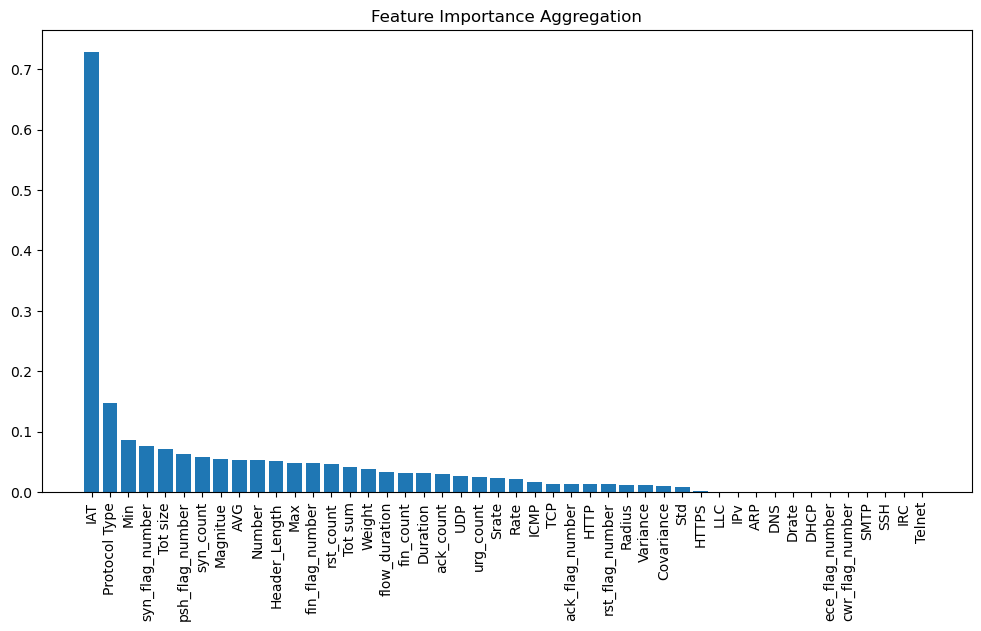

Ensemble Test Accuracy with Optimal Feature Set: 0.9827
Classification Report:
                         precision    recall  f1-score   support

          BenignTraffic       0.84      0.96      0.90       114
        DDoS-ICMP_Flood       1.00      1.00      1.00       745
         DDoS-UDP_Flood       1.00      1.00      1.00       592
         DDoS-TCP_Flood       1.00      1.00      1.00       450
      DDoS-PSHACK_Flood       1.00      1.00      1.00       414
         DDoS-SYN_Flood       1.00      1.00      1.00       400
       DDoS-RSTFINFlood       1.00      1.00      1.00       403
DDoS-SynonymousIP_Flood       1.00      1.00      1.00       374
DDoS-ICMP_Fragmentation       0.93      0.98      0.95        42
 DDoS-UDP_Fragmentation       0.83      0.89      0.86        27
 DDoS-ACK_Fragmentation       0.75      1.00      0.86        21
        DDoS-HTTP_Flood       0.21      0.75      0.33         4
         DDoS-SlowLoris       0.43      1.00      0.60         3
          

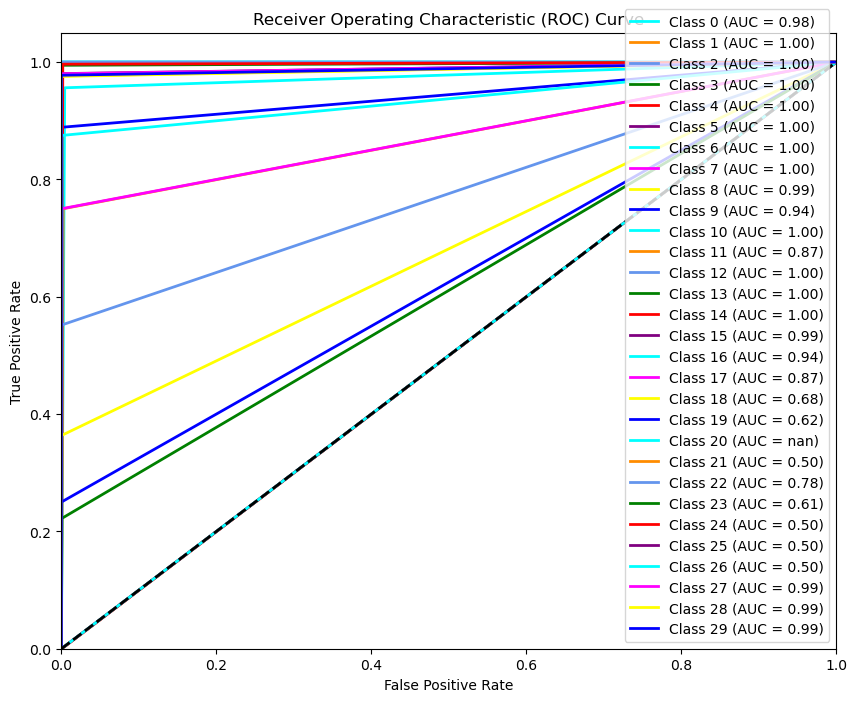

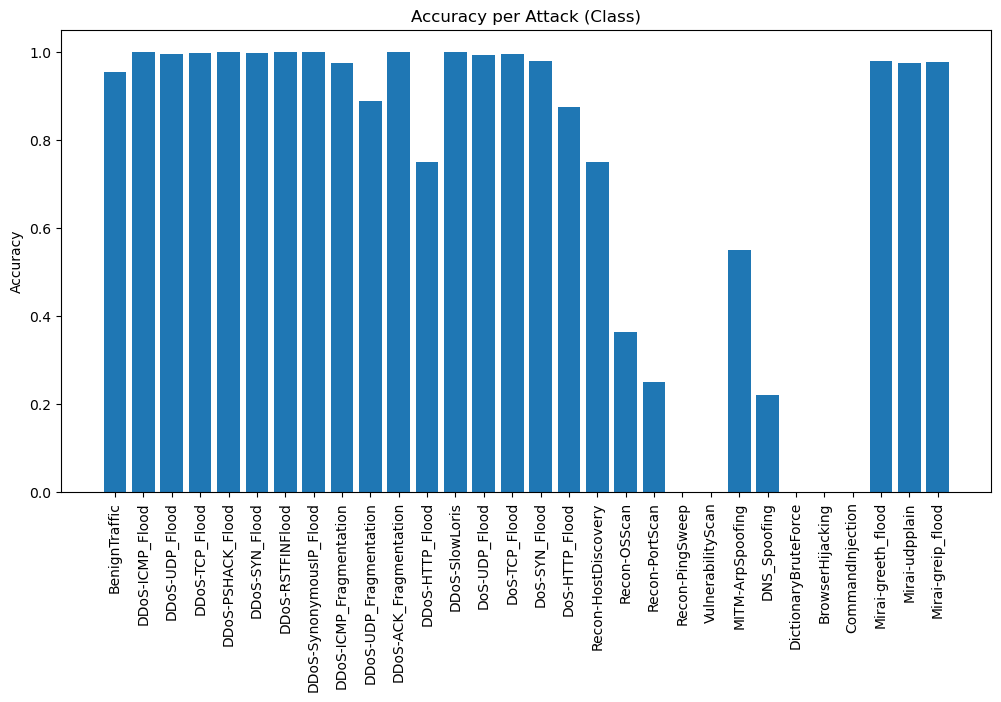

AdaBoost Training Time: 5.8471 seconds
Random Forest Training Time: 3.3278 seconds
AdaBoost (Selected Features) Training Time: 3.4266 seconds
Random Forest (Selected Features) Training Time: 2.5893 seconds
Testing Time: 0.3177 seconds


In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle
import time
import warnings
warnings.filterwarnings("ignore")

# Load and preprocess the dataset
df = pd.read_csv(r'C:\Users\Administrator\Downloads\code\explainable AI\archive\cicds2023.csv', engine='python')
print(df)

# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df = df.fillna(0)

# Mapping for multi-class labels
mapping = {
    'BenignTraffic': 0, 'DDoS-ICMP_Flood': 1, 'DDoS-UDP_Flood': 2, 'DDoS-TCP_Flood': 3, 'DDoS-PSHACK_Flood': 4,
    'DDoS-SYN_Flood': 5, 'DDoS-RSTFINFlood': 6, 'DDoS-SynonymousIP_Flood': 7, 'DDoS-ICMP_Fragmentation': 8,
    'DDoS-UDP_Fragmentation': 9, 'DDoS-ACK_Fragmentation': 10, 'DDoS-HTTP_Flood': 11, 'DDoS-SlowLoris': 12,
    'DoS-UDP_Flood': 13, 'DoS-TCP_Flood': 14, 'DoS-SYN_Flood': 15, 'DoS-HTTP_Flood': 16, 'Recon-HostDiscovery': 17,
    'Recon-OSScan': 18, 'Recon-PortScan': 19, 'Recon-PingSweep': 20, 'VulnerabilityScan': 21, 'MITM-ArpSpoofing': 22,
    'DNS_Spoofing': 23, 'DictionaryBruteForce': 24, 'BrowserHijacking': 25, 'XSS': 26, 'Uploading_Attack': 27,
    'SqlInjection': 28, 'CommandInjection': 29, 'Backdoor_Malware': 30, 'Mirai-greeth_flood': 31, 'Mirai-udpplain': 32,
    'Mirai-greip_flood': 33
}
df['label'] = df['label'].map(mapping)

# Select a subset of the data
df = df.sample(frac=0.1, random_state=42)  # Using 10% of the data for faster processing
X = df.drop(columns=["label"])
y = df["label"]

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 1. Base Models: AdaBoost and Random Forest
# AdaBoost
start_time = time.time()
ada_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=50, random_state=42)
ada_model.fit(X_train, y_train)
ada_training_time = time.time() - start_time

# Random Forest
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_training_time = time.time() - start_time

# 2. Feature Importance Aggregation
# Get feature importances
ada_importances = ada_model.feature_importances_
rf_importances = rf_model.feature_importances_

# Aggregate feature importances
aggregated_importances = ada_importances + rf_importances

# Sort features by importance
sorted_indices = np.argsort(aggregated_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(X_train.shape[1]), aggregated_importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X.columns[sorted_indices], rotation=90)
plt.title('Feature Importance Aggregation')
plt.show()

# 3. Optimal Feature Set Selection
# Define the number of top features to select
top_features = 21
selected_features = sorted_indices[:top_features]

# Reduce the dataset to the top features
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# 4. Retrain Models with Optimal Feature Set
# Retrain AdaBoost
start_time = time.time()
ada_model_selected = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=50, random_state=42)
ada_model_selected.fit(X_train_selected, y_train)
ada_training_time_selected = time.time() - start_time

# Retrain Random Forest
start_time = time.time()
rf_model_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_selected.fit(X_train_selected, y_train)
rf_training_time_selected = time.time() - start_time

# 5. Ensemble Voting
def ensemble_predict(models, X):
    # Get predictions from each model
    predictions = [model.predict(X) for model in models]
    # Majority voting (hard voting)
    final_predictions = np.array(predictions).mean(axis=0).round().astype(int)
    return final_predictions

# List of models
models_selected = [ada_model_selected, rf_model_selected]

# Predict on test set with optimal features
start_time = time.time()
y_pred = ensemble_predict(models_selected, X_test_selected)
testing_time = time.time() - start_time

# Evaluate ensemble accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Ensemble Test Accuracy with Optimal Feature Set: {accuracy:.4f}')

# 6. Classification Report
# Find unique classes in the predictions and test set
unique_classes = np.unique(np.concatenate((y_test, y_pred)))
# Create a list of present class names based on unique_classes
present_class_names = [list(mapping.keys())[list(mapping.values()).index(i)] for i in unique_classes]
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=present_class_names))

# 7. Confusion Matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred, labels=unique_classes)
print(conf_matrix)

# 8. Calculate False Positive Rate (FPR)
# FPR = FP / (FP + TN) for each class
fpr_values = {}
for i, class_name in enumerate(present_class_names):
    tn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fpr_values[class_name] = fpr

print("False Positive Rate per Class:")
for class_name, fpr in fpr_values.items():
    print(f"{class_name}: {fpr:.4f}")

# 9. Plot ROC Curve and Calculate AUC for each class
y_test_bin = label_binarize(y_test, classes=unique_classes)
n_classes = y_test_bin.shape[1]

y_pred_bin = np.zeros_like(y_test_bin)
for i in range(n_classes):
    y_pred_bin[:, i] = (y_pred == unique_classes[i])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'cyan', 'magenta', 'yellow', 'blue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 10. Plot Accuracy for Each Attack (Class)
accuracy_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
plt.figure(figsize=(12, 6))
plt.bar(range(len(unique_classes)), accuracy_per_class, align='center')
plt.xticks(range(len(unique_classes)), present_class_names, rotation=90)
plt.ylabel('Accuracy')
plt.title('Accuracy per Attack (Class)')
plt.show()

# Print training and testing times
print(f'AdaBoost Training Time: {ada_training_time:.4f} seconds')
print(f'Random Forest Training Time: {rf_training_time:.4f} seconds')
print(f'AdaBoost (Selected Features) Training Time: {ada_training_time_selected:.4f} seconds')
print(f'Random Forest (Selected Features) Training Time: {rf_training_time_selected:.4f} seconds')
print(f'Testing Time: {testing_time:.4f} seconds')


        flow_duration  Header_Length  Protocol Type  Duration         Rate  \
0            0.000000           2.06          46.59     63.78     1.397840   
1            0.000000          54.00           6.00     64.00     2.130290   
2            0.007771           3.30          42.14     82.46     7.248154   
3            0.327774          96.06           6.00     64.00     4.346313   
4            0.100559       42845.28          16.78     65.91  8829.262382   
...               ...            ...            ...       ...          ...   
240041       0.011324          33.52           1.38     62.21    30.468957   
240042       0.124466       40434.00          16.83     63.36  7622.399807   
240043       0.022697          66.84           6.22     66.55     1.131130   
240044       0.000000           0.00           1.00     64.00    18.243148   
240045       1.397100         113.94           6.00     64.00     2.344105   

              Srate  Drate  fin_flag_number  syn_flag_number  r

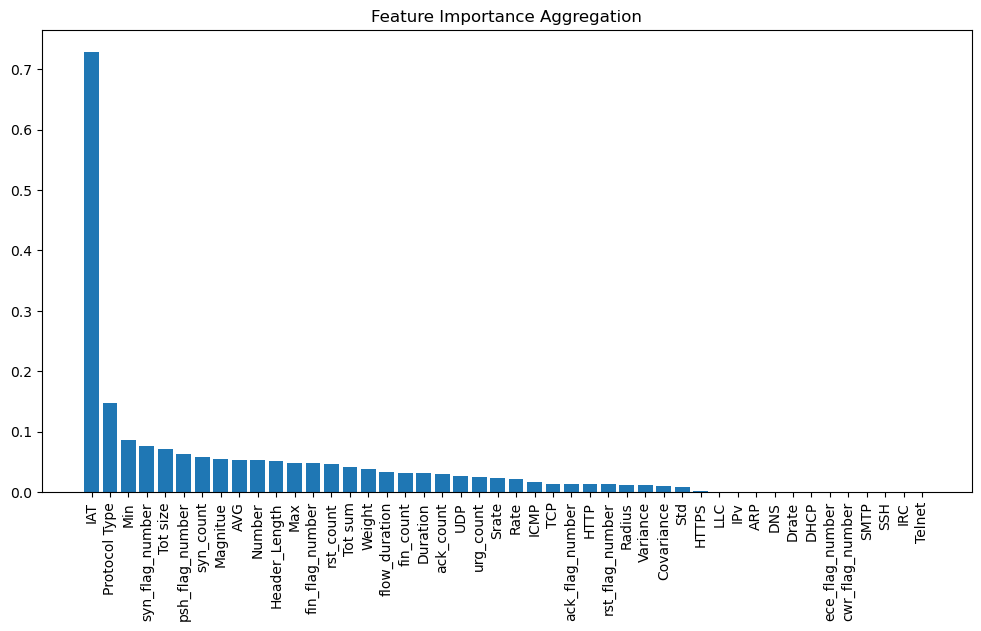

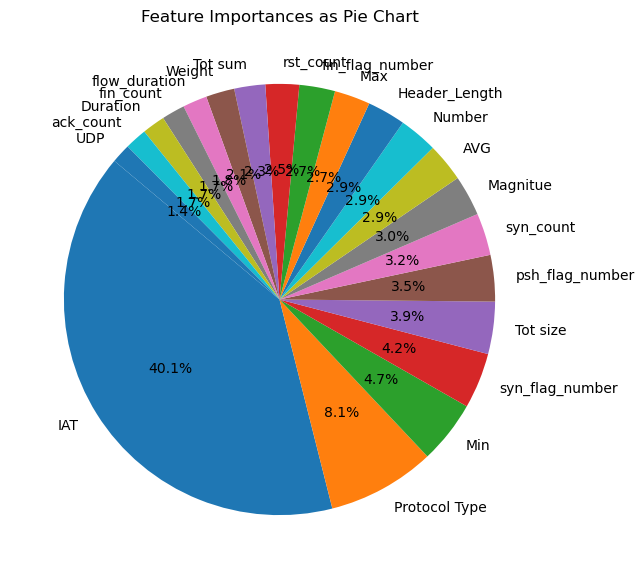

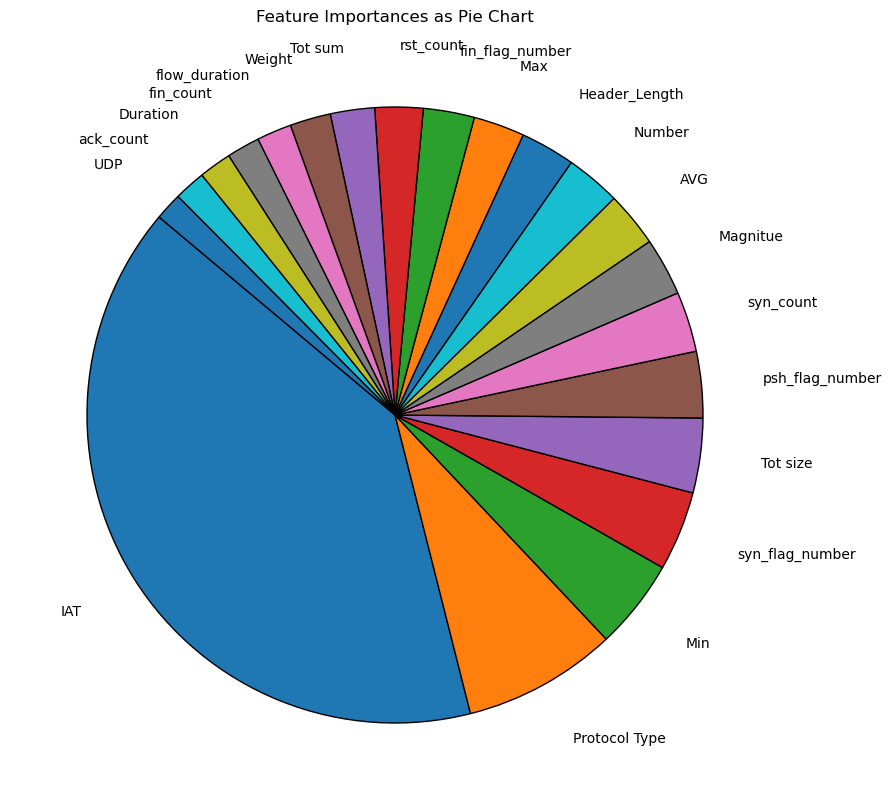

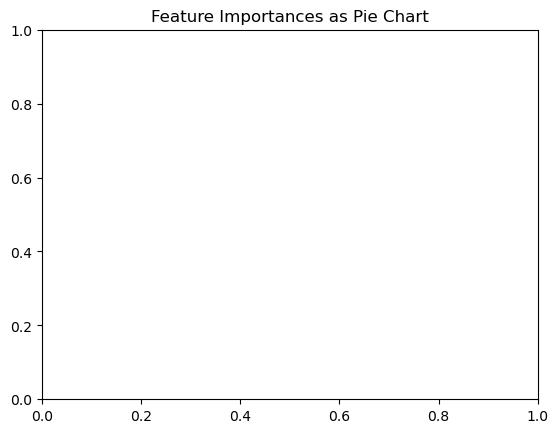

Ensemble Test Accuracy with Optimal Feature Set: 0.9827
Classification Report:
                         precision    recall  f1-score   support

          BenignTraffic       0.84      0.96      0.90       114
        DDoS-ICMP_Flood       1.00      1.00      1.00       745
         DDoS-UDP_Flood       1.00      1.00      1.00       592
         DDoS-TCP_Flood       1.00      1.00      1.00       450
      DDoS-PSHACK_Flood       1.00      1.00      1.00       414
         DDoS-SYN_Flood       1.00      1.00      1.00       400
       DDoS-RSTFINFlood       1.00      1.00      1.00       403
DDoS-SynonymousIP_Flood       1.00      1.00      1.00       374
DDoS-ICMP_Fragmentation       0.93      0.98      0.95        42
 DDoS-UDP_Fragmentation       0.83      0.89      0.86        27
 DDoS-ACK_Fragmentation       0.75      1.00      0.86        21
        DDoS-HTTP_Flood       0.21      0.75      0.33         4
         DDoS-SlowLoris       0.43      1.00      0.60         3
          

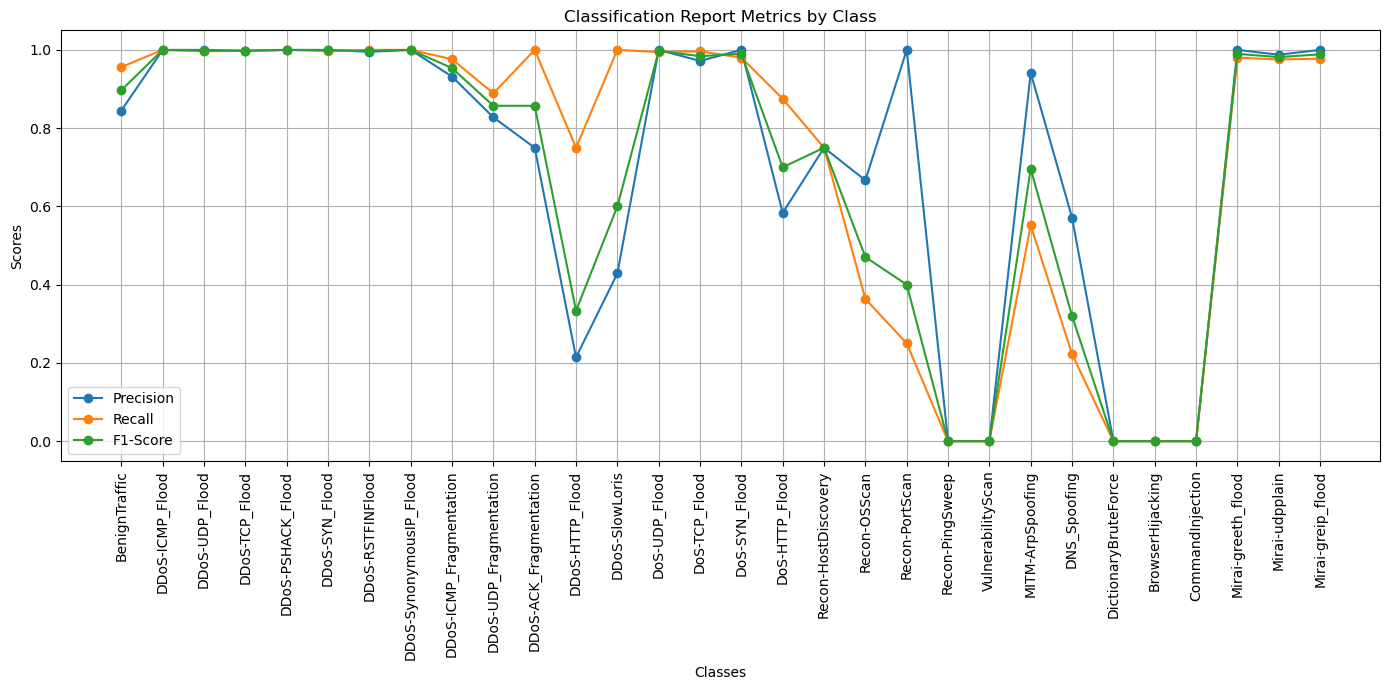

Confusion Matrix:
[[109   0   0   0   0   0   0   0   0   0   0   4   0   0   0   0   0   0
    0   0   0   0   0   1   0   0   0   0   0   0]
 [  0 745   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 590   0   0   0   0   0   1   0   0   0   1   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 449   0   0   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 414   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 399   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 403   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 374   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0

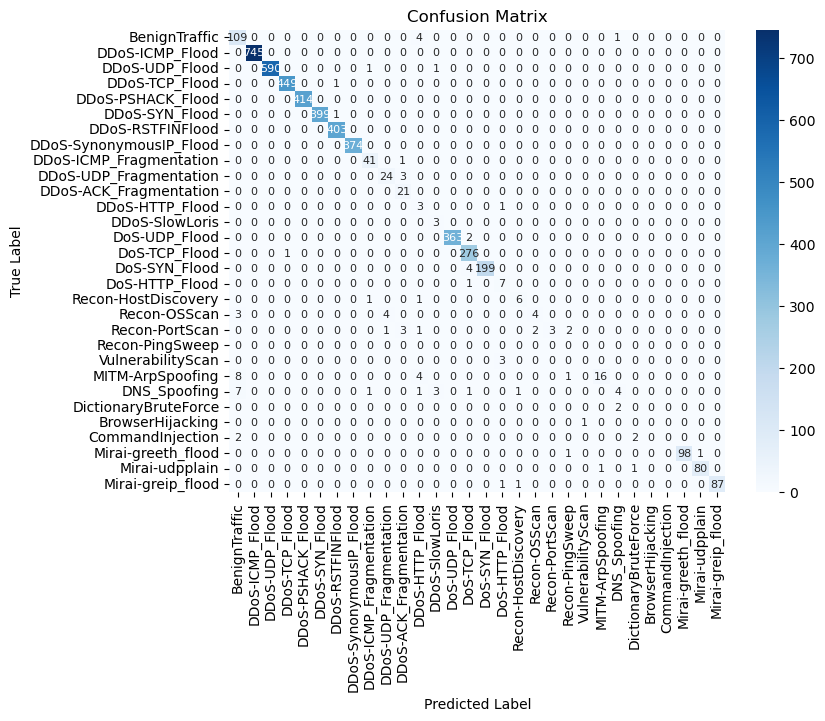

False Positive Rate per Class:
BenignTraffic: 0.8000
DDoS-ICMP_Flood: 0.0000
DDoS-UDP_Flood: 0.0000
DDoS-TCP_Flood: 0.5000
DDoS-PSHACK_Flood: 0.0000
DDoS-SYN_Flood: 0.0000
DDoS-RSTFINFlood: 1.0000
DDoS-SynonymousIP_Flood: 0.0000
DDoS-ICMP_Fragmentation: 0.7500
DDoS-UDP_Fragmentation: 0.6250
DDoS-ACK_Fragmentation: 1.0000
DDoS-HTTP_Flood: 0.9167
DDoS-SlowLoris: 1.0000
DoS-UDP_Flood: 0.0000
DoS-TCP_Flood: 0.8889
DoS-SYN_Flood: 0.0000
DoS-HTTP_Flood: 0.8333
Recon-HostDiscovery: 0.5000
Recon-OSScan: 0.2222
Recon-PortScan: 0.0000
Recon-PingSweep: 1.0000
VulnerabilityScan: 0.2500
MITM-ArpSpoofing: 0.0714
DNS_Spoofing: 0.1765
DictionaryBruteForce: 0.6000
BrowserHijacking: 0.0000
CommandInjection: 0.0000
Mirai-greeth_flood: 0.0000
Mirai-udpplain: 0.3333
Mirai-greip_flood: 0.0000
False Positive Rate per Class:
BenignTraffic: 0.0043
DDoS-ICMP_Flood: 0.0000
DDoS-UDP_Flood: 0.0000
DDoS-TCP_Flood: 0.0002
DDoS-PSHACK_Flood: 0.0000
DDoS-SYN_Flood: 0.0000
DDoS-RSTFINFlood: 0.0005
DDoS-SynonymousIP_Flo

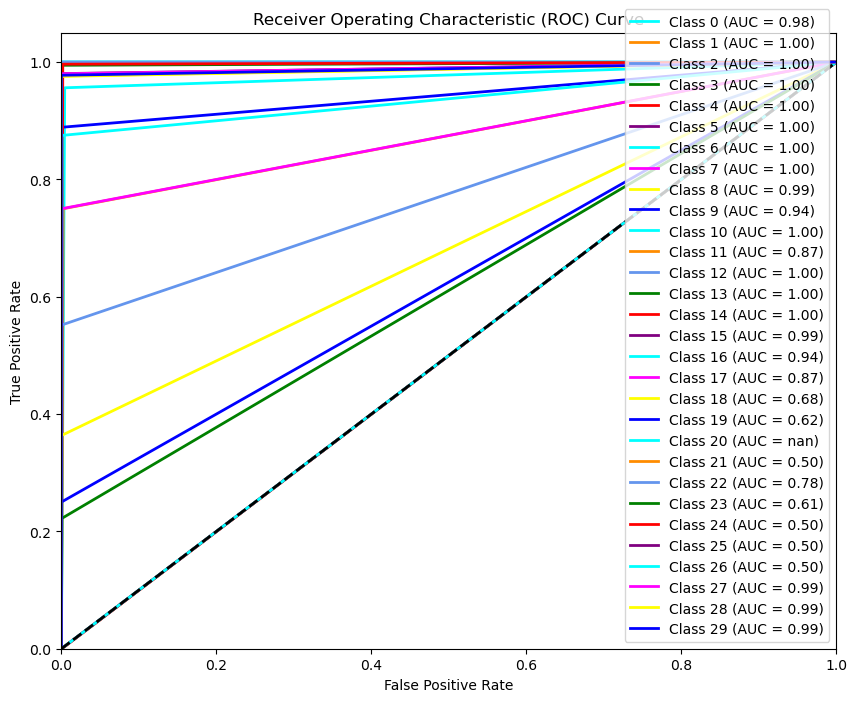

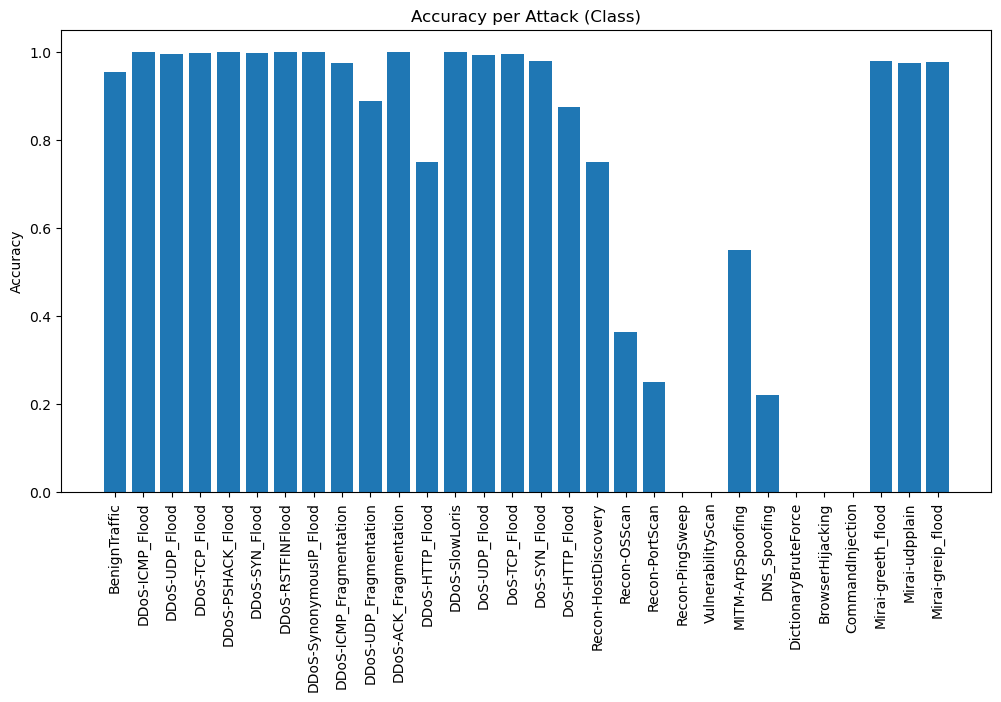

AdaBoost Training Time: 2.4140 seconds
Random Forest Training Time: 1.3121 seconds
AdaBoost (Selected Features) Training Time: 1.5151 seconds
Random Forest (Selected Features) Training Time: 1.0952 seconds
Testing Time: 0.1563 seconds


In [44]:
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle
import time
import warnings
warnings.filterwarnings("ignore")

# Load and preprocess the dataset
df = pd.read_csv(r'C:\Users\Administrator\Downloads\code\explainable AI\archive\cicds2023.csv', engine='python')
print(df)

# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df = df.fillna(0)

# Mapping for multi-class labels
mapping = {
    'BenignTraffic': 0, 'DDoS-ICMP_Flood': 1, 'DDoS-UDP_Flood': 2, 'DDoS-TCP_Flood': 3, 'DDoS-PSHACK_Flood': 4,
    'DDoS-SYN_Flood': 5, 'DDoS-RSTFINFlood': 6, 'DDoS-SynonymousIP_Flood': 7, 'DDoS-ICMP_Fragmentation': 8,
    'DDoS-UDP_Fragmentation': 9, 'DDoS-ACK_Fragmentation': 10, 'DDoS-HTTP_Flood': 11, 'DDoS-SlowLoris': 12,
    'DoS-UDP_Flood': 13, 'DoS-TCP_Flood': 14, 'DoS-SYN_Flood': 15, 'DoS-HTTP_Flood': 16, 'Recon-HostDiscovery': 17,
    'Recon-OSScan': 18, 'Recon-PortScan': 19, 'Recon-PingSweep': 20, 'VulnerabilityScan': 21, 'MITM-ArpSpoofing': 22,
    'DNS_Spoofing': 23, 'DictionaryBruteForce': 24, 'BrowserHijacking': 25, 'XSS': 26, 'Uploading_Attack': 27,
    'SqlInjection': 28, 'CommandInjection': 29, 'Backdoor_Malware': 30, 'Mirai-greeth_flood': 31, 'Mirai-udpplain': 32,
    'Mirai-greip_flood': 33
}
df['label'] = df['label'].map(mapping)

# Select a subset of the data
df = df.sample(frac=0.1, random_state=42)  # Using 10% of the data for faster processing
X = df.drop(columns=["label"])
y = df["label"]

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 1. Base Models: AdaBoost and Random Forest
# AdaBoost
start_time = time.time()
ada_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=50, random_state=42)
ada_model.fit(X_train, y_train)
ada_training_time = time.time() - start_time

# Random Forest
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_training_time = time.time() - start_time

# 2. Feature Importance Aggregation
# Get feature importances
ada_importances = ada_model.feature_importances_
rf_importances = rf_model.feature_importances_

# Aggregate feature importances
aggregated_importances = ada_importances + rf_importances

# Sort features by importance
sorted_indices = np.argsort(aggregated_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(X_train.shape[1]), aggregated_importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X.columns[sorted_indices], rotation=90)
plt.title('Feature Importance Aggregation')
plt.show()

# Calculate aggregated feature importances
aggregated_importances = ada_importances + rf_importances

# Sort features by importance
sorted_indices = np.argsort(aggregated_importances)[::-1]

# Define the number of top features to select
top_features = 21
selected_indices = sorted_indices[:top_features]

# Get the feature names and importances for the top features
top_feature_names = X.columns[selected_indices]
top_feature_importances = aggregated_importances[selected_indices]

# Plot the feature importances as a pie chart
plt.figure(figsize=(10, 7))
plt.pie(top_feature_importances, labels=top_feature_names, autopct='%1.1f%%', startangle=140)
plt.title('Feature Importances as Pie Chart')
plt.show()

# Increase the figure size and reduce the font size of feature names
plt.figure(figsize=(14, 10))  # Increase the size of the figure
plt.pie(
    top_feature_importances,
    labels=top_feature_names,
    autopct=None,  # Remove percentages
    startangle=140,
    labeldistance=1.2,  # Distance of labels from the center
    textprops={'fontsize': 10},  # Reduce the font size of the labels
    wedgeprops={'linewidth': 1, 'edgecolor': 'black'}  # Optional: add black edges for better distinction
)
plt.title('Feature Importances as Pie Chart')
plt.show()

plt.title('Feature Importances as Pie Chart')
plt.show()

# 3. Optimal Feature Set Selection
# Define the number of top features to select
top_features = 21
selected_features = sorted_indices[:top_features]

# Reduce the dataset to the top features
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# 4. Retrain Models with Optimal Feature Set
# Retrain AdaBoost
start_time = time.time()
ada_model_selected = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=50, random_state=42)
ada_model_selected.fit(X_train_selected, y_train)
ada_training_time_selected = time.time() - start_time

# Retrain Random Forest
start_time = time.time()
rf_model_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_selected.fit(X_train_selected, y_train)
rf_training_time_selected = time.time() - start_time

# 5. Ensemble Voting
def ensemble_predict(models, X):
    # Get predictions from each model
    predictions = [model.predict(X) for model in models]
    # Majority voting (hard voting)
    final_predictions = np.array(predictions).mean(axis=0).round().astype(int)
    return final_predictions

# List of models
models_selected = [ada_model_selected, rf_model_selected]

# Predict on test set with optimal features
start_time = time.time()
y_pred = ensemble_predict(models_selected, X_test_selected)
testing_time = time.time() - start_time

# Evaluate ensemble accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Ensemble Test Accuracy with Optimal Feature Set: {accuracy:.4f}')

# 6. Classification Report
# Find unique classes in the predictions and test set
unique_classes = np.unique(np.concatenate((y_test, y_pred)))
# Create a list of present class names based on unique_classes
present_class_names = [list(mapping.keys())[list(mapping.values()).index(i)] for i in unique_classes]
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=present_class_names))
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=present_class_names, output_dict=True)

# Extract precision, recall, and f1-score for each class
classes = list(report.keys())[:-3]  # Ignore 'accuracy', 'macro avg', 'weighted avg'
precision = [report[class_name]['precision'] for class_name in classes]
recall = [report[class_name]['recall'] for class_name in classes]
f1_score = [report[class_name]['f1-score'] for class_name in classes]

# Plot the precision, recall, and f1-score
plt.figure(figsize=(14, 7))
plt.plot(classes, precision, label='Precision', marker='o')
plt.plot(classes, recall, label='Recall', marker='o')
plt.plot(classes, f1_score, label='F1-Score', marker='o')
plt.xticks(rotation=90)
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Classification Report Metrics by Class')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Confusion Matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred, labels=unique_classes)
print(conf_matrix)
import seaborn as sns

# 7. Colorful Confusion Matrix
import seaborn as sns

# 7. Colorful Confusion Matrix
plt.figure(figsize=(8, 6))  # Adjust the figure size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=present_class_names, yticklabels=present_class_names,
            annot_kws={"size": 8})  # Reduce font size for annotations
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# 8. Calculate False Positive Rate (FPR)
# FPR = FP / (FP + TN) for each class
fpr_values = {}
for i, class_name in enumerate(present_class_names):
    tn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fpr_values[class_name] = fpr

print("False Positive Rate per Class:")
for class_name, fpr in fpr_values.items():
    print(f"{class_name}: {fpr:.4f}")
# 8. Calculate False Positive Rate (FPR)
# FPR = FP / (FP + TN) for each class
fpr_values = {}
fpr_sum = 0
for i, class_name in enumerate(present_class_names):
    # False Positives (FP): Sum of the column i in the confusion matrix minus the diagonal element
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    # True Negatives (TN): Sum of all elements in the matrix minus the sum of the row i and column i, plus the diagonal element
    tn = np.sum(conf_matrix) - (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - conf_matrix[i, i])
    # False Positive Rate (FPR)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fpr_values[class_name] = fpr
    fpr_sum += fpr

average_fpr = fpr_sum / len(present_class_names)

print("False Positive Rate per Class:")
for class_name, fpr in fpr_values.items():
    print(f"{class_name}: {fpr:.4f}")

print(f"Average False Positive Rate: {average_fpr:.4f}")

# 9. Plot ROC Curve and Calculate AUC for each class
y_test_bin = label_binarize(y_test, classes=unique_classes)
n_classes = y_test_bin.shape[1]

y_pred_bin = np.zeros_like(y_test_bin)
for i in range(n_classes):
    y_pred_bin[:, i] = (y_pred == unique_classes[i])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'cyan', 'magenta', 'yellow', 'blue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 10. Plot Accuracy for Each Attack (Class)
accuracy_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
plt.figure(figsize=(12, 6))
plt.bar(range(len(unique_classes)), accuracy_per_class, align='center')
plt.xticks(range(len(unique_classes)), present_class_names, rotation=90)
plt.ylabel('Accuracy')
plt.title('Accuracy per Attack (Class)')
plt.show()

# Print training and testing times
print(f'AdaBoost Training Time: {ada_training_time:.4f} seconds')
print(f'Random Forest Training Time: {rf_training_time:.4f} seconds')
print(f'AdaBoost (Selected Features) Training Time: {ada_training_time_selected:.4f} seconds')
print(f'Random Forest (Selected Features) Training Time: {rf_training_time_selected:.4f} seconds')
print(f'Testing Time: {testing_time:.4f} seconds')


In [14]:
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

# Load and preprocess the dataset
df = pd.read_csv(r'C:\Users\Administrator\Downloads\code\explainable AI\archive\cicds2023.csv', engine='python')
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df = df.fillna(0)

# Mapping for multi-class labels
mapping = {
    'BenignTraffic': 0, 'DDoS-ICMP_Flood': 1, 'DDoS-UDP_Flood': 2, 'DDoS-TCP_Flood': 3, 'DDoS-PSHACK_Flood': 4,
    'DDoS-SYN_Flood': 5, 'DDoS-RSTFINFlood': 6, 'DDoS-SynonymousIP_Flood': 7, 'DDoS-ICMP_Fragmentation': 8,
    'DDoS-UDP_Fragmentation': 9, 'DDoS-ACK_Fragmentation': 10, 'DDoS-HTTP_Flood': 11, 'DDoS-SlowLoris': 12,
    'DoS-UDP_Flood': 13, 'DoS-TCP_Flood': 14, 'DoS-SYN_Flood': 15, 'DoS-HTTP_Flood': 16, 'Recon-HostDiscovery': 17,
    'Recon-OSScan': 18, 'Recon-PortScan': 19, 'Recon-PingSweep': 20, 'VulnerabilityScan': 21, 'MITM-ArpSpoofing': 22,
    'DNS_Spoofing': 23, 'DictionaryBruteForce': 24, 'BrowserHijacking': 25, 'XSS': 26, 'Uploading_Attack': 27,
    'SqlInjection': 28, 'CommandInjection': 29, 'Backdoor_Malware': 30, 'Mirai-greeth_flood': 31, 'Mirai-udpplain': 32,
    'Mirai-greip_flood': 33
}
df['label'] = df['label'].map(mapping)

# Select a subset of the data
df = df.sample(frac=0.1, random_state=42)  # Using 10% of the data for faster processing
X = df.drop(columns=["label"])
y = df["label"]

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check the available columns in the dataset
print("Available columns in the dataset:", df.columns)

# Define expert rules (example rules based on available columns)
def expert_rules(instance):
    # Example rule: if a certain feature exceeds a threshold, classify as attack type 1
    if 'Dst Port' in df.columns and instance['Dst Port'] == 80:  # HTTP traffic
        return 11  # Example: Classify as 'DDoS-HTTP_Flood'
    elif 'Protocol' in df.columns and instance['Protocol'] == 1:  # ICMP traffic
        return 1  # Example: Classify as 'DDoS-ICMP_Flood'
    # Add more rules based on the available columns and domain knowledge
    return None  # No rule matches

# Apply expert rules to the dataset
def apply_expert_system(X):
    y_pred = np.full(X.shape[0], -1)  # Initialize predictions with -1 (unknown)
    for i in range(X.shape[0]):
        rule_result = expert_rules(df.iloc[i])
        if rule_result is not None:
            y_pred[i] = rule_result
    return y_pred

# Apply expert system to test set
y_pred_expert = apply_expert_system(X_test)

# Determine which instances need to go through ML models (where expert system couldn't classify)
ml_indices = (y_pred_expert == -1)

# Train ensemble models (if not already trained)
# AdaBoost
ada_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=50, random_state=42)
ada_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)




Available columns in the dataset: Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label'],
      dtype='object')
Combined System Accuracy: 0.9827
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       114
           1       1.00      1.00      1.00       745
           2       1.00      1.00      1.00       592
           3       1.00      1.00      1.00       450
           4       1.00      1.

In [28]:
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
import time

# Load and preprocess the dataset
df = pd.read_csv(r'C:\Users\Administrator\Downloads\code\explainable AI\archive\cicds2023.csv', engine='python')
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df = df.fillna(0)

# Mapping for multi-class labels
mapping = {
    'BenignTraffic': 0, 'DDoS-ICMP_Flood': 1, 'DDoS-UDP_Flood': 2, 'DDoS-TCP_Flood': 3, 'DDoS-PSHACK_Flood': 4,
    'DDoS-SYN_Flood': 5, 'DDoS-RSTFINFlood': 6, 'DDoS-SynonymousIP_Flood': 7, 'DDoS-ICMP_Fragmentation': 8,
    'DDoS-UDP_Fragmentation': 9, 'DDoS-ACK_Fragmentation': 10, 'DDoS-HTTP_Flood': 11, 'DDoS-SlowLoris': 12,
    'DoS-UDP_Flood': 13, 'DoS-TCP_Flood': 14, 'DoS-SYN_Flood': 15, 'DoS-HTTP_Flood': 16, 'Recon-HostDiscovery': 17,
    'Recon-OSScan': 18, 'Recon-PortScan': 19, 'Recon-PingSweep': 20, 'VulnerabilityScan': 21, 'MITM-ArpSpoofing': 22,
    'DNS_Spoofing': 23, 'DictionaryBruteForce': 24, 'BrowserHijacking': 25, 'XSS': 26, 'Uploading_Attack': 27,
    'SqlInjection': 28, 'CommandInjection': 29, 'Backdoor_Malware': 30, 'Mirai-greeth_flood': 31, 'Mirai-udpplain': 32,
    'Mirai-greip_flood': 33
}
df['label'] = df['label'].map(mapping)

# Select a subset of the data
df = df.sample(frac=0.1, random_state=42)  # Using 10% of the data for faster processing
df = shuffle(df, random_state=42)
X = df.drop(columns=["label"])
y = df["label"]

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into clients
num_clients = 3
client_data = np.array_split(df, num_clients)
client_labels = np.array_split(y, num_clients)

# Define expert rules (example rules based on available columns)
def expert_rules(instance):
    # Example rule: if a certain feature exceeds a threshold, classify as attack type 1
    if 'Dst Port' in df.columns and instance['Dst Port'] == 80:  # HTTP traffic
        return 11  # Example: Classify as 'DDoS-HTTP_Flood'
    elif 'Protocol' in df.columns and instance['Protocol'] == 1:  # ICMP traffic
        return 1  # Example: Classify as 'DDoS-ICMP_Flood'
    # Add more rules based on the available columns and domain knowledge
    return None  # No rule matches

# Apply expert rules to the dataset
def apply_expert_system(X):
    y_pred = np.full(X.shape[0], -1)  # Initialize predictions with -1 (unknown)
    for i in range(X.shape[0]):
        rule_result = expert_rules(df.iloc[i])
        if rule_result is not None:
            y_pred[i] = rule_result
    return y_pred

# Federated learning: Training local models on each client
def train_local_models(X, y):
    local_models = []
    for i in range(num_clients):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        ada_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=50, random_state=42)
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

        ada_model.fit(X_train, y_train)
        rf_model.fit(X_train, y_train)

        local_models.append((ada_model, rf_model))
    return local_models

# Function to aggregate models' weights (for simplicity, averaging parameters)
def aggregate_models(local_models):
    num_models = len(local_models)

    # Initialize parameters for averaging
    avg_rf_importances = np.zeros_like(local_models[0][1].feature_importances_)
    ada_predictions = None

    for ada_model, rf_model in local_models:
        # Sum the feature importances of RandomForest models
        avg_rf_importances += rf_model.feature_importances_

        # Sum the predictions of AdaBoost models (using predict_proba)
        ada_preds = np.sum([tree.predict_proba(X_train) for tree in ada_model.estimators_], axis=0)
        if ada_predictions is None:
            ada_predictions = ada_preds
        else:
            ada_predictions += ada_preds

    # Average the feature importances for RandomForest
    avg_rf_importances /= num_models

    # Average the predictions for AdaBoost
    ada_predictions /= num_models

    # Create a new RandomForest model (a "dummy" model for demonstration)
    avg_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    avg_rf_model.fit(np.zeros((1, len(avg_rf_importances))), [0])  # Dummy fit
    avg_rf_model._custom_importances = avg_rf_importances  # Store the aggregated importances

    # Create a new AdaBoost model (a "dummy" model for demonstration)
    avg_ada_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=50, random_state=42)
    avg_ada_model.fit(np.zeros((1, X_train.shape[1])), [0])  # Dummy fit

    # We need to replace the predict_proba method of the AdaBoost estimators with the averaged one
    def averaged_predict_proba(X):
        return ada_predictions

    for i, tree in enumerate(avg_ada_model.estimators_):
        tree.predict_proba = averaged_predict_proba

    return avg_ada_model, avg_rf_model

# Example of accessing the custom feature importances
def get_feature_importances(model):
    if hasattr(model, '_custom_importances'):
        return model._custom_importances
    else:
        return model.feature_importances_

# Usage
num_rounds = 5
for round_num in range(num_rounds):
    local_models = train_local_models(X, y)  # Assuming this function is defined elsewhere
    global_models = aggregate_models(local_models)
    print(f'Round {round_num + 1} completed.')

# Simulate federated learning rounds
num_rounds = 5
global_models = None
for round_num in range(num_rounds):
    local_models = train_local_models(X, y)
    global_models = aggregate_models(local_models)
    print(f'Round {round_num + 1} completed.')

# Use global models for final evaluation
ada_model, rf_model = global_models

# Apply expert system to the entire test set (assuming `X_test` and `y_test` are global)
y_pred_expert = apply_expert_system(X)

# Determine which instances need to go through ML models (where expert system couldn't classify)
ml_indices = (y_pred_expert == -1)

# Predict with the global model
import numpy as np

def ensemble_predict(models, X):
    """
    Make predictions using an ensemble of models and return the majority vote.
    
    Parameters:
    - models: List of models (each model should implement the predict method)
    - X: Input data for prediction
    
    Returns:
    - final_predictions: Array of predicted labels
    """
    # Ensure all models' predictions are in the same format
    predictions = []
    for model in models:
        preds = model.predict(X)
        # If predict method returns probabilities, convert to class labels
        if preds.ndim == 2 and preds.shape[1] > 1:
            preds = np.argmax(preds, axis=1)
        predictions.append(preds)
    
    # Stack predictions and use majority voting (hard voting)
    predictions = np.vstack(predictions)
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
    return final_predictions

# Select the top features based on importance or a predefined set
selected_features = [0, 1, 2, 3, 4]  # Example selected feature indices, update as needed

# Subset the dataset to only the selected features
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# Train the models using only the selected features
# AdaBoost
ada_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=50, random_state=42)
ada_model.fit(X_train_selected, y_train)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train)

# Aggregate models as done previously
global_models = aggregate_models([(ada_model, rf_model)])  # Assuming local models have been aggregated

# Use the selected features for predictions
y_pred_ml = ensemble_predict(global_models, X_test_selected)

# Merge expert system and ML predictions
y_pred_combined = y_pred_expert.copy()
y_pred_combined[ml_indices] = y_pred_ml

# Evaluate combined system
accuracy = accuracy_score(y_test, y_pred_combined)
print(f'Combined System Accuracy: {accuracy:.4f}')

# Further evaluation and reporting...


# Ensemble prediction using the global model
y_pred_ml = ensemble_predict(global_models, X_selected_ml)

# Merge expert system and ML predictions
y_pred_combined = y_pred_expert.copy()
y_pred_combined[ml_indices] = y_pred_ml

# Evaluate combined system
accuracy = accuracy_score(y_test, y_pred_combined)
print(f'Combined System Accuracy: {accuracy:.4f}')

# Further evaluation and reporting...

# Assuming all features are selected (replace with actual feature selection if needed)
selected_features = np.arange(X.shape[1])
X_selected_ml = X[:, selected_features]

# Ensemble prediction using the global model
y_pred_ml = ensemble_predict(global_models, X_selected_ml)

# Merge expert system and ML predictions
y_pred_combined = y_pred_expert.copy()
y_pred_combined[ml_indices] = y_pred_ml

# Evaluate combined system
accuracy = accuracy_score(y, y_pred_combined)
print(f'Combined System Accuracy: {accuracy:.4f}')

# Classification report and confusion matrix
print("Classification Report:")
print(classification_report(y, y_pred_combined))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y, y_pred_combined)
print(conf_matrix)

# Calculate false positive rate
false_positive_rate = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
false_positive_rate = false_positive_rate / conf_matrix.sum(axis=0)
print("False Positive Rate:", false_positive_rate)

# Measure testing time
start_test_time = time.time()
ensemble_predict(global_models, X_selected_ml)
end_test_time = time.time()
testing_time = end_test_time - start_test_time
print(f"Testing Time: {testing_time:.2f} seconds")


Round 1 completed.
Round 2 completed.
Round 3 completed.
Round 4 completed.
Round 5 completed.
Round 1 completed.
Round 2 completed.
Round 3 completed.
Round 4 completed.
Round 5 completed.


ValueError: X has 46 features, but DecisionTreeClassifier is expecting 5 features as input.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle
import time
import warnings
warnings.filterwarnings("ignore")

# Load and preprocess the dataset
df = pd.read_csv(r'C:\Users\Administrator\Downloads\code\explainable AI\archive\cicds2023.csv', engine='python')
print(df)

# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df = df.fillna(0)

# Mapping for multi-class labels
mapping = {
    'BenignTraffic': 0, 'DDoS-ICMP_Flood': 1, 'DDoS-UDP_Flood': 2, 'DDoS-TCP_Flood': 3, 'DDoS-PSHACK_Flood': 4,
    'DDoS-SYN_Flood': 5, 'DDoS-RSTFINFlood': 6, 'DDoS-SynonymousIP_Flood': 7, 'DDoS-ICMP_Fragmentation': 8,
    'DDoS-UDP_Fragmentation': 9, 'DDoS-ACK_Fragmentation': 10, 'DDoS-HTTP_Flood': 11, 'DDoS-SlowLoris': 12,
    'DoS-UDP_Flood': 13, 'DoS-TCP_Flood': 14, 'DoS-SYN_Flood': 15, 'DoS-HTTP_Flood': 16, 'Recon-HostDiscovery': 17,
    'Recon-OSScan': 18, 'Recon-PortScan': 19, 'Recon-PingSweep': 20, 'VulnerabilityScan': 21, 'MITM-ArpSpoofing': 22,
    'DNS_Spoofing': 23, 'DictionaryBruteForce': 24, 'BrowserHijacking': 25, 'XSS': 26, 'Uploading_Attack': 27,
    'SqlInjection': 28, 'CommandInjection': 29, 'Backdoor_Malware': 30, 'Mirai-greeth_flood': 31, 'Mirai-udpplain': 32,
    'Mirai-greip_flood': 33
}
df['label'] = df['label'].map(mapping)

# Select a subset of the data
df = df.sample(frac=0.1, random_state=42)  # Using 10% of the data for faster processing
X = df.drop(columns=["label"])
y = df["label"]

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 1. Base Models: AdaBoost and Random Forest
# AdaBoost
start_time = time.time()
ada_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=50, random_state=42)
ada_model.fit(X_train, y_train)
ada_training_time = time.time() - start_time

# Random Forest
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_training_time = time.time() - start_time

# 2. Feature Importance Aggregation
# Get feature importances
ada_importances = ada_model.feature_importances_
rf_importances = rf_model.feature_importances_

# Aggregate feature importances
aggregated_importances = ada_importances + rf_importances

# Sort features by importance
sorted_indices = np.argsort(aggregated_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(X_train.shape[1]), aggregated_importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X.columns[sorted_indices], rotation=90)
plt.title('Feature Importance Aggregation')
plt.show()

# 3. Optimal Feature Set Selection
# Define the number of top features to select
top_features = 21
selected_features = sorted_indices[:top_features]

# Reduce the dataset to the top features
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# 4. Retrain Models with Optimal Feature Set
# Retrain AdaBoost
start_time = time.time()
ada_model_selected = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=50, random_state=42)
ada_model_selected.fit(X_train_selected, y_train)
ada_training_time_selected = time.time() - start_time

# Retrain Random Forest
start_time = time.time()
rf_model_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_selected.fit(X_train_selected, y_train)
rf_training_time_selected = time.time() - start_time

# 5. Ensemble Voting
def ensemble_predict(models, X):
    # Get predictions from each model
    predictions = [model.predict(X) for model in models]
    # Majority voting (hard voting)
    final_predictions = np.array(predictions).mean(axis=0).round().astype(int)
    return final_predictions

# List of models
models_selected = [ada_model_selected, rf_model_selected]

# Predict on test set with optimal features
start_time = time.time()
y_pred = ensemble_predict(models_selected, X_test_selected)
testing_time = time.time() - start_time

# Evaluate ensemble accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Ensemble Test Accuracy with Optimal Feature Set: {accuracy:.4f}')

# 6. Classification Report
# Find unique classes in the predictions and test set
unique_classes = np.unique(np.concatenate((y_test, y_pred)))
# Create a list of present class names based on unique_classes
present_class_names = [list(mapping.keys())[list(mapping.values()).index(i)] for i in unique_classes]
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=present_class_names))

# 7. Confusion Matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred, labels=unique_classes)
print(conf_matrix)

# 8. Calculate False Positive Rate (FPR)
# FPR = FP / (FP + TN) for each class
fpr_values = {}
for i, class_name in enumerate(present_class_names):
    tn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fpr_values[class_name] = fpr

print("False Positive Rate per Class:")
for class_name, fpr in fpr_values.items():
    print(f"{class_name}: {fpr:.4f}")

# 9. Plot ROC Curve and Calculate AUC for each class
y_test_bin = label_binarize(y_test, classes=unique_classes)
n_classes = y_test_bin.shape[1]

y_pred_bin = np.zeros_like(y_test_bin)
for i in range(n_classes):
    y_pred_bin[:, i] = (y_pred == unique_classes[i])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'cyan', 'magenta', 'yellow', 'blue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 10. Plot Accuracy for Each Attack (Class)
accuracy_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
plt.figure(figsize=(12, 6))
plt.bar(range(len(unique_classes)), accuracy_per_class, align='center')
plt.xticks(range(len(unique_classes)), present_class_names, rotation=90)
plt.ylabel('Accuracy')
plt.title('Accuracy per Attack (Class)')
plt.show()

# Print training and testing times
print(f'AdaBoost Training Time: {ada_training_time:.4f} seconds')
print(f'Random Forest Training Time: {rf_training_time:.4f} seconds')
print(f'AdaBoost (Selected Features) Training Time: {ada_training_time_selected:.4f} seconds')
print(f'Random Forest (Selected Features) Training Time: {rf_training_time_selected:.4f} seconds')
print(f'Testing Time: {testing_time:.4f} seconds')